# Fake News Project
The goal of this project is to create a fake news prediction system. Fake news is a major problem that can have serious negative effects on how people understand the world around them. You will work with a dataset containing real and fake news in order to train a simple and a more advanced classifier to solve this problem. This project covers the full Data Science pipeline, from data processing, to modelling, to visualization and interpretation.
## Part 1 Data Processing

### Task 1

In [ ]:
import pandas as pd 
df = pd.read_csv("news_sample.csv")
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
import re
import nltk
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from cleantext import clean


def clean_text(text):
  clean_text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
  clean_text = clean(clean_text,
    lower=True,
    no_urls=True, replace_with_url="<URL>",
    no_emails=True, replace_with_email="<EMAIL>",
    no_numbers=True, replace_with_number= r"<NUM>",
    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
    no_punct=True, replace_with_punct="",
    no_line_breaks=True 
  )
  return clean_text

def rmv_stopwords(tokens):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

def stem_tokens(tokens):
  stemmer=PorterStemmer()
  Output=[stemmer.stem(word) for word in tokens]
  return Output

# build a vocabulary from a dataframe with list of tokens
def build_vocabulary(df_tokens):
    # Flatten the list of tokens
  tokens = []
  for lst in df_tokens:
    tokens += lst
  fq = FreqDist(tokens)
  return fq

In [ ]:
dfcpy = df.copy()

dfcpy.content = dfcpy.content.apply(clean_text)

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)

vocab = build_vocabulary(dfcpy.tokenized)
vocab_size = vocab.B()
print("After cleaning:")
print(f"vocabulary size: {vocab_size}\n")

dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)
vocab = build_vocabulary(dfcpy.tokenized)
# reduction rate of the vocabulary size
reduction = ((vocab_size - vocab.B())/vocab_size)*100
vocab_size = vocab.B()
print("After removing stopwords:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")

dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)
vocab = build_vocabulary(dfcpy.tokenized)
reduction = ((vocab_size - vocab.B())/vocab_size)*100
vocab_size = vocab.B()
print("After stemming:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction:.2f}%\n")


1. counting the number of URLs in the content
2. counting the number of dates in the content
3. counting the number of numeric values in the content
4. determining the 100 more frequent words that appear in the content
5. plot the frequency of the 10000 most frequent words (any interesting patterns?)
6. run the analysis in point 4 and 5 both before and after removing stopwords and applying stemming: do you see any difference?


In [ ]:
#pip install "modin[ray]" (only works in python 3.10)
import modin.pandas as pd

In [ ]:
df = pd.read_csv("995,000_rows.csv", usecols=['content', 'type', 'url', 'title', 'authors', 'domain'], engine='c', dtype = str)
dfcpy = df.copy()
dfcpy = dfcpy.dropna(subset=['content'])
dfcpy = dfcpy.dropna(subset=['type'])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq(fq, top_n):
  common_words = fq.most_common(top_n)

  all_freq = dict(common_words)

  plt.figure(figsize = (top_n*0.1, 5))
  plt.xticks(rotation = 90,fontsize = 5)
  sns.lineplot(x = list(all_freq.keys()), y = list(all_freq.values()), color = 'red')
  sns.barplot(x = list(all_freq.keys()), y = list(all_freq.values()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.grid(axis = 'y')
  plt.show()
  return

In [ ]:
dfcpy.content = dfcpy.content.apply(clean_text)

In [ ]:
tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
dfcpy["tokenized"] = dfcpy.content.apply(tokenizer.tokenize)


In [ ]:
dfcpy.tokenized = dfcpy.tokenized.apply(rmv_stopwords)

In [ ]:
dfcpy.tokenized = dfcpy.tokenized.apply(stem_tokens)

## Data exploration

In [ ]:
vocab = build_vocabulary(dfcpy.tokenized)

In [ ]:
def plot_domain_with_type(df):
  top_domains = df.domain.value_counts().head(20).index
  df = df[df.domain.isin(top_domains)]
  df = df.groupby(['domain', 'type']).size().unstack().fillna(0)

  df.plot(kind='bar', stacked=True, figsize=(10,5), title='Domain distribution with types')
  plt.show()
  return


num_freq = vocab.get("<num>",0)
plot_freq(vocab, 100)

# top 20 domains with their types
plot_domain_with_type(dfcpy)

# pie chart for the distribution of the types
dfcpy.type.value_counts().plot.pie(autopct='%1.1f%%', figsize=(10,5), title='Types distribution')
plt.show()

# ammount of dropped rows
print(f"Number of dropped rows: {df.shape[0] - dfcpy.shape[0]}")

In [ ]:
dfcpy.tokenized = dfcpy.tokenized.apply(lambda x: ' '.join(x))
dfcpy.to_csv('cleaned_news.csv', index=False)

# Task 4

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('cleaned_news.csv', usecols=['tokenized', 'type'], engine='c', dtype = str)
dfcpy = df.copy()
# label is 1 if the article is fake, 0 if the article is reliable
dfcpy['label'] = dfcpy['type'].map({'fake': 1, 'conspiracy': 1, 'junksci': 1, 'bias': 1, 'clickbait': 0, 'political': 0, 'reliable': 0})
dfcpy = dfcpy.dropna(subset=['label'])
dfcpy['label'] = dfcpy['label'].astype(int)

X = dfcpy['tokenized']
y = dfcpy['label']
X.dropna(inplace=True)
y = y.loc[X.index]


train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 42) 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size= test_ratio / (test_ratio + validation_ratio), random_state = 42)

print("Training Set:")
print(x_train.head())


Training Set:
242324    <num> views0 like <url> resid visitor greet ne...
156478    deposit rs <num> lakh quot pan mandatori say c...
895410    team finnish american biologist report identif...
562228    kevin durant penetr paint finish tough layup w...
509352    updat fantasi footbal preseason run back rank ...
Name: tokenized, dtype: object


In [2]:
## Create a new split using x amount of each type of article
type_amount = 500

dfcpy_subset = dfcpy.groupby('type').head(type_amount)
print("Number of articles of each type in the new dataset:"
        ,dfcpy['type'].value_counts())

X = dfcpy_subset['tokenized']
y = dfcpy_subset['label']
X.dropna(inplace=True)
y = y.loc[X.index]


train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

x_train_subset, x_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size = 1 - train_ratio, random_state = 42)
x_val_subset, x_test_subset, y_val_subset, y_test_subset = train_test_split(x_test_subset, y_test_subset, test_size= test_ratio / (test_ratio + validation_ratio), random_state = 42)

print("Training subset size:", x_train_subset.shape[0])

x_train_subset = x_train_subset.apply(lambda x: np.str_(x))
x_val_subset = x_val_subset.apply(lambda x: np.str_(x))
x_test_subset = x_test_subset.apply(lambda x: np.str_(x))

Number of articles of each type in the new dataset: type
reliable      218563
political     194518
bias          133232
fake          104883
conspiracy     97314
clickbait      27412
junksci        14040
Name: count, dtype: int64
Training subset size: 2800


/tmp/ipykernel_6951/3726140203.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


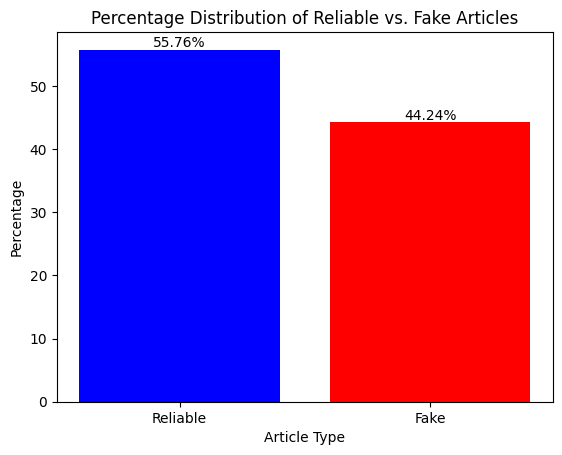

In [3]:
# Examine the percentage distribution of 'reliable' vs. 'fake' articles
grouped_type = dfcpy['label'].value_counts()
grouped_type = grouped_type / grouped_type.sum() * 100

# make a bar plot with percentages on bars
plt.bar([0, 1], grouped_type, tick_label=['Reliable', 'Fake'], color=['blue', 'red'])
plt.text(0, grouped_type[0], f'{grouped_type[0]:.2f}%', ha='center', va='bottom')
plt.text(1, grouped_type[1], f'{grouped_type[1]:.2f}%', ha='center', va='bottom')
plt.xlabel('Article Type')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Reliable vs. Fake Articles')
plt.show()

In [ ]:
# import sklearn.metrics as metrics
# import seaborn as sns
# def evaluate_model(y_val, y_pred):
#     # Confusion matrix
#     confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=[1, 0])
#     sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])

#     accuracy = metrics.accuracy_score(y_val, y_pred)
#     f1 = metrics.f1_score(y_val, y_pred)
#     print("f1 score:", f1)
#     print("accuracy:", accuracy)

# Part 2: A simple model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
import seaborn as sns

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase = False,
                                   max_features = 10000, 
                                   token_pattern=r'<[\w]+>|[\w]+')), 
    ('scaler', StandardScaler(with_mean=False))
    ])


X_train_TFIDF = pipeline.fit_transform(x_train, y_train) 
X_val_TFIDF = pipeline.transform(x_val)
X_test_TFIDF = pipeline.transform(x_test)

model = LogisticRegression(max_iter=10000)
model.fit(X_train_TFIDF, y_train)

y_pred = model.predict(X_val_TFIDF)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy:", accuracy)

# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_val, y_pred, labels=[1, 0])
sns.heatmap(confusion_matrix, 
            annot=True, 
            fmt='g', 
            cmap='Blues', 
            xticklabels=['fake', 'real'], 
            yticklabels=['fake', 'real'])

# Part 3: Advanced model

3 models: 
- LinearSVM
- Naive bayes
- Random forrest

2 vector representations:
- TF-IDF, 2 grams
- Word embedding (word2vec)

We perfrom cross validation on hyper paramaters to find the best hyperparameters for each model 

## Vectorization

###  TF-IDF vectorizer

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


def make_TFIDF(x_train, y_train, x_val, x_test, features, ngrams):
    pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase = False, 
                                   max_features=features, 
                                   min_df = 10, 
                                   max_df= 0.9, 
                                   token_pattern=r'<[\w]+>|[\w]+',
                                   ngram_range =  ngrams)),
    ('scaler', StandardScaler(with_mean=False)),
    ])
    X_train_TFIDF = pipeline.fit_transform(x_train, y_train) 
    X_val_TFIDF = pipeline.transform(x_val)
    X_test_TFIDF = pipeline.transform(x_test)
    return X_train_TFIDF, X_val_TFIDF, X_test_TFIDF


# Doc2vec

In [ ]:
# from gensim.models import Doc2Vec
# from gensim.models.doc2vec import TaggedDocument
# from nltk.tokenize import word_tokenize
# import tensorflow as tf
# import numpy as np
# doc2vec_model = Doc2Vec(documents=[TaggedDocument(words= word_tokenize(doc), tags=[i]) for i, doc in enumerate(x_train)], vector_size=100, window=5, min_count=1)

# tokenizer = tf.keras.preprocessing.text.Tokenizer()
# tokenizer.fit_on_texts(x_train)
# word_index = tokenizer.word_index

# x_train_sequences = tokenizer.texts_to_sequences(x_train)
# x_val_sequences = tokenizer.texts_to_sequences(x_val)
# x_test_sequences = tokenizer.texts_to_sequences(x_test)

# def sequences_to_doc2vec_embeddings(model, sequences, tokenizer):
#     embeddings = []
#     for sequence in sequences:
#         words = tokenizer.sequences_to_texts([sequence])[0].split()  # Convert integers back to words
#         vector = model.infer_vector(words)
#         embeddings.append(vector)
#     return np.array(embeddings)

# X_train_D2V = sequences_to_doc2vec_embeddings(doc2vec_model, x_train_sequences, tokenizer)
# X_val_D2V = sequences_to_doc2vec_embeddings(doc2vec_model, x_val_sequences, tokenizer)
# X_test_D2V = sequences_to_doc2vec_embeddings(doc2vec_model, x_test_sequences, tokenizer)

On subset:

In [ ]:
type_amount = 1000

dfcpy_subset = dfcpy.groupby('type').head(type_amount)
print("Number of articles of each type in the new dataset:"
        ,dfcpy['type'].value_counts())

X = dfcpy_subset['tokenized']
y = dfcpy_subset['label']
X.dropna(inplace=True)
y = y.loc[X.index]


train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10



new version

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=1, epochs = 10)

# Sample labeled data
tagged_tokens = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(X)]

doc2vec_model.build_vocab(tagged_tokens)

doc2vec_model.train(tagged_tokens, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# doc_vectors = [doc2vec_model.dv[idx] for idx in range(len(tagged_tokens))]

doc_vectors = [doc2vec_model.infer_vector(word_tokenize(doc)) for doc in X]

X_train_D2V_subset, X_test_D2V_subset, y_train_subset, y_test_subset = train_test_split(doc_vectors, 
                                                                                        y, 
                                                                                        test_size = 1 - train_ratio, 
                                                                                        random_state = 42)
X_val_D2V_subset, X_test_D2V_subse, y_val_subset, y_test_subset = train_test_split(x_test_subset, 
                                                                                   y_test_subset, 
                                                                                   test_size= test_ratio / (test_ratio + validation_ratio), 
                                                                                   random_state = 42)

print("Training subset size:", x_train_subset.shape[0])


## Model 1: Linear SVC 

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

def svc_advanced(x_train, y_train, x_val):
    svc = LinearSVC(dual=False, max_iter=10000) 
    parameters = dict(C=[0.001 ,0.1, 1], tol=[1e-3, 0.1, 1])
    # Cross-validation
    grid_search = GridSearchCV(svc, parameters, cv=3, n_jobs=19, scoring = 'f1')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    
    return grid_search.predict(x_val)

### TF-IDF 

In [ ]:
import sklearn.metrics as metrics
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(x_train, 
                                                      y_train, 
                                                      x_val, 
                                                      x_test, 
                                                      10000, 
                                                      (1,1)) 
y_pred = svc_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy:", accuracy)

In [ ]:
import sklearn.metrics as metrics
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(x_train, 
                                                      y_train, 
                                                      x_val, 
                                                      x_test, 
                                                      10000, 
                                                      (1,2)) 
y_pred = svc_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy:", accuracy)

In [ ]:
import sklearn.metrics as metrics
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(x_train, 
                                                      y_train, 
                                                      x_val, 
                                                      x_test, 
                                                      10000, 
                                                      (3,3)) 
y_pred = svc_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy:", accuracy)

### Doc2vec

In [ ]:
y_pred = svc_advanced(X_train_D2V, y_train, X_val_D2V)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy:", accuracy)

doc2vec on subset

In [ ]:
y_pred = svc_advanced(X_train_D2V_subset, y_train_subset, X_val_D2V_subset)
accuracy = metrics.accuracy_score(y_val_subset, y_pred)
f1 = metrics.f1_score(y_val_subset, y_pred)
print("f1 score:", f1)
print("accuracy:", accuracy)

## Model 2: Naive bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.metrics as metrics

def nb_advanced(x_train, y_train, x_val):
    nb = MultinomialNB()
    parameters = dict(alpha=[0.1, 1, 10])
    # Cross-validation
    grid_search = GridSearchCV(nb, parameters, cv=3, n_jobs=19, scoring = 'f1')
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)
    
    return grid_search.predict(x_val)

### TF-IDF

In [ ]:
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(x_train, 
                                                      y_train, 
                                                      x_val, 
                                                      x_test, 
                                                      None, 
                                                      (1,1)) 
y_pred = nb_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy:", accuracy)

In [ ]:
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(x_train, 
                                                      y_train, 
                                                      x_val, 
                                                      x_test, 
                                                      None, 
                                                      (1,2)) 
y_pred = nb_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy:", accuracy)

In [ ]:
X_train_TFIDF, X_val_TFIDF, X_test_TFIDF = make_TFIDF(x_train, 
                                                      y_train, 
                                                      x_val, 
                                                      x_test, 
                                                      None, 
                                                      (3,3)) 
y_pred = nb_advanced(X_train_TFIDF, y_train, X_val_TFIDF)
accuracy = metrics.accuracy_score(y_val, y_pred)
f1 = metrics.f1_score(y_val, y_pred)
print("f1 score:", f1)
print("accuracy:", accuracy)